100%|██████████| 9912422/9912422 [00:00<00:00, 140742822.47it/s]

Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 22667607.38it/s]


Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 43864468.31it/s]

Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 13120198.88it/s]


Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw

-4.4991989786436815
-1.1347775652464518
0.7971339113930903
1.6822120975583856
2.2684417919817763
2.5779798300281516
2.743981627767274
2.8875773578310318
2.9940220196364025
3.0638781874927123


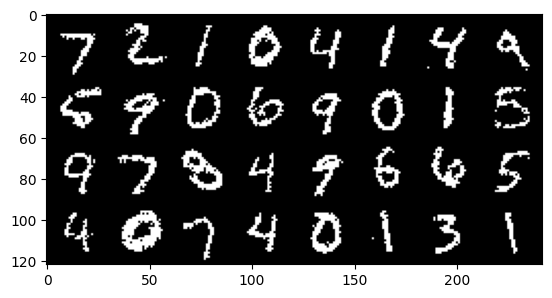

In [ ]:
#!/usr/bin/env python
# coding: utf-8
"""
RBM 원래 코드 출처: https://github.com/odie2630463/Restricted-Boltzmann-Machines-in-pytorch
공돌이의 수학정리노트 - RBM편
"""
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid


#%% 시각화를 위해 필요한 함수

# get_ipython().run_line_magic('matplotlib', 'inline') # inline 출력 필요한 경우 주석 처리 제거할 것.
import matplotlib.pyplot as plt

def show_adn_save(file_name,img):
    """
    이미지 출력해주고 세이브 해주는 역할의 함수
    """
    npimg = np.transpose(img.numpy(),(1,2,0))
    f = "./%s.png" % file_name
    plt.imshow(npimg)
    plt.imsave(f,npimg)


#%% RBM 모듈 만들기
class RBM(nn.Module):
    def __init__(self,
                 n_vis=784,
                 n_hin=500,
                 k=5):
        super(RBM, self).__init__()
        # 여타 initialization에 비해 이와 같은 방식이 학습이 제일 잘 됨.
        self.W = nn.Parameter(torch.randn(n_hin,n_vis)*1e-2)
        self.v_bias = nn.Parameter(torch.zeros(n_vis)) # bias는 0으로 초기화.
        self.h_bias = nn.Parameter(torch.zeros(n_hin)) # bias는 0으로 초기화.

        self.k = k # Contrastive Divergence의 횟수

    def sample_from_p(self,p):
        # Gibbs Sampling 과정
        # 확률 계산 후 uniform distribution으로부터 얻은 값 보다 크면 1, 아니면 -1로 출력하고
        # relu 함수를 이용해 -1로 출력된 값들은 모두 0으로 처리해버림.
        p_ = p - Variable(torch.rand(p.size()))
        p_sign = torch.sign(p_)
        return F.relu(p_sign)

    def v_to_h(self,v):
        # 주어진 visible units로부터 hidden unit을 sampling하는 과정
        p_h = torch.sigmoid(F.linear(v,self.W,self.h_bias))
        sample_h = self.sample_from_p(p_h)
        return p_h,sample_h

    def h_to_v(self,h):
        # hidden unit의 샘플로부터 visible unit을 다시 복원해보는 과정
        p_v = torch.sigmoid(F.linear(h,self.W.t(),self.v_bias))
        sample_v = self.sample_from_p(p_v)
        return p_v,sample_v

    def forward(self,v):
        # RBM에서 forward propagation은 visible -> hidden -> 다시 visible로
        # hidden unit과 visible unit을 샘플링 하는 과정을 말함.
        pre_h1,h1 = self.v_to_h(v)

        h_ = h1
        for _ in range(self.k): # Contrastive Divergence를 k 번 수행함.
            pre_v_,v_ = self.h_to_v(h_)
            pre_h_,h_ = self.v_to_h(v_)

        # 아래의 v는 입력으로 들어온 v이고 v_는 sampling으로 얻은 h로부터 다시 획득한 입력 샘플
        return v,v_

    def free_energy(self,v):
        # Free Energy 계산
        vbias_term = v.mv(self.v_bias) # mv: matrix - vector product
        wx_b = F.linear(v,self.W,self.h_bias)

        temp = torch.log(
            torch.exp(wx_b) + 1
            )
        hidden_term = torch.sum(temp, dim = 1)

        return (-hidden_term - vbias_term).mean()


#%% 데이터 셋 불러오기: MNIST 이용
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./MNIST_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./MNIST_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size)


#%% RBM 모델 객체 및 최적화 함수 객체 만들기

rbm = RBM(k=1) # CD의 k = 1로 설정.
# 즉, visible unit을 딱 한번만 sampling 해주고
# 그걸로 원래의 visible unit의 데이터와 configuration 비교해서 loss로 삼겠다는 의미.
train_op = optim.Adam(rbm.parameters(), 0.005) # 어떤 Optimizer를 넣어줘도 무관함.

#%% RBM 학습

for epoch in range(10):
    loss_ = []
    for _, (data,target) in enumerate(train_loader): # Stochastic Gradient Descent 수행함.
        data = Variable(data.view(-1,784))
        sample_data = data.bernoulli() # RBM의 입력은 0 또는 1의 값만 가져야 함.

        v,v1 = rbm(sample_data)
        loss = rbm.free_energy(v) - rbm.free_energy(v1)
        loss_.append(loss.data.item())
        train_op.zero_grad()
        loss.backward() # RBM의 Backpropagation은 원래의 입력과 sampling 된 입력간의 차이를 줄여주는 과정
        train_op.step()

    print(np.mean(loss_))

#%% Test Data로부터 원본 데이터와 샘플링된 입력 데이터를 비교해보자.

testset = datasets.MNIST('./MNIST_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ]))

sample_data = testset.data[:32,:].view(-1, 784) # 총 32개 데이터를 받아옴.
sample_data = sample_data.type(torch.FloatTensor)/255.

v, v1 = rbm(sample_data)
show_adn_save("real_testdata",make_grid(v.view(32,1,28,28).data))
show_adn_save("generated_testdata",make_grid(v1.view(32,1,28,28).data))


real data


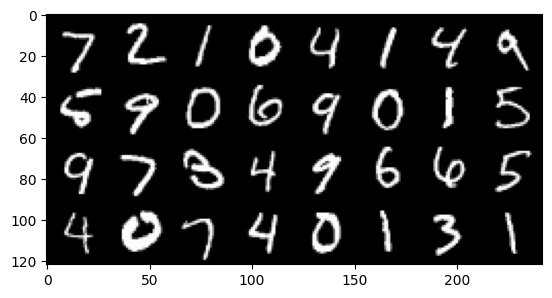

In [ ]:
print('real data')
show_adn_save("real_testdata",make_grid(v.view(32,1,28,28).data))

reconstruct data


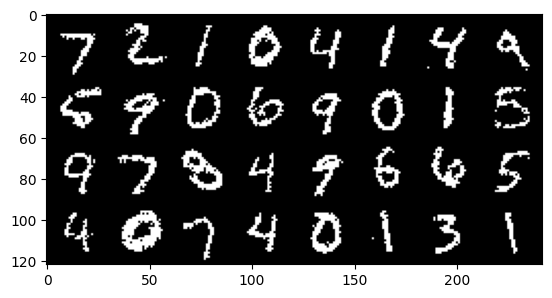

In [ ]:
print('reconstruct data')
show_adn_save("generated_testdata",make_grid(v1.view(32,1,28,28).data))